# Modelo 1 Random Forest con todas las variables y GridSearch

### Carga y división de datos

In [47]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [36]:
# Carga de datos
df_impagos = pd.read_csv('../Datos/Crudos/Loan_default.csv')
df_impagos.drop(columns=['LoanID'], inplace=True)
df_impagos.sample(5)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
30397,58,98944,219539,832,105,3,7.45,36,0.33,High School,Self-employed,Married,Yes,Yes,Other,No,0
19080,27,71507,242556,516,46,4,18.61,24,0.76,Master's,Part-time,Divorced,No,Yes,Education,Yes,0
143711,28,106035,242033,512,75,2,9.95,36,0.50,High School,Unemployed,Married,No,No,Education,Yes,0
45831,66,77593,153055,372,25,1,21.19,60,0.80,Bachelor's,Full-time,Married,Yes,Yes,Auto,No,0
145727,36,67036,100408,599,5,4,6.15,36,0.52,PhD,Full-time,Married,No,Yes,Business,No,0


In [37]:
# División de los datos
X = df_impagos.drop(columns=['Default'])
y = df_impagos.Default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Creación de pipeline

In [38]:
# Dividir columnas categóricas
columnas_categoricas = X.select_dtypes(include='object').columns.to_list()

# Preprocesador con OneHotEncoder
preprocesador = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), columnas_categoricas)
    ], remainder='passthrough'
)

In [39]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', RandomForestClassifier(random_state=42))
    ]
)

In [43]:
# Malla para revisión de hiperparámetros
malla_hp = {
    'modelo__n_estimators' : [100, 200],
    'modelo__max_depth' : [None, 10, 20],
    'modelo__min_samples_split' : [2, 5],
    'modelo__min_samples_leaf' : [1, 2]
}

In [ ]:
# Creación de GridSearch
grid = GridSearchCV(
    estimator = pipeline,
    param_grid = malla_hp,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1,
    verbose = 1
)

# Sampleamos X y Y para probar el GridSearch
X_sample = X.sample(frac=0.2, random_state=42)
y_sample = y.loc[X_sample.index]

grid.fit(X_sample, y_sample)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Education',
                                                                          'EmploymentType',
                                                                          'MaritalStatus',
                                                                          'HasMortgage',
                                                                          'HasDependents',
                                                                          'LoanPurpose',
                                                                          'HasCoSigner'])])),
                                       ('modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'modelo__max_depth': [None, 10, 20],
                         'modelo__min_samples_leaf': [1, 2],
                         'modelo__min_samples_split': [2, 5],
                         'modelo__n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [45]:
# Mejores hiperparámetros
print("Mejores parámetros:", grid.best_params_)

# Mejor score en validación cruzada
print("Mejor score Validación cruzada:", grid.best_score_)

# Evaluación sobre el test set
mejor_modelo = grid.best_estimator_
accuracy_test = mejor_modelo.score(X_test, y_test)
print("Accuracy en test set:", accuracy_test)

Mejores parámetros: {'modelo__max_depth': None, 'modelo__min_samples_leaf': 1, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 100}
Mejor score Validación cruzada: 0.885919058573627
Accuracy en test set: 0.9443117289994126


### Evaluación del modelo

In [46]:
# Predicciones
mejor_modelo.fit(X_train, y_train)
y_train_pred = mejor_modelo.predict(X_train)
y_test_pred = mejor_modelo.predict(X_test)

In [48]:
# Cálculo de accuracy train
train_accuracy = accuracy_score(y_train, y_train_pred)

# Cálculo de accuracy train
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Accuracy train:', train_accuracy)
print('Accuracy test:', test_accuracy)

Accuracy train: 0.9749023732530687
Accuracy test: 0.8856863129038575


In [49]:
# Reporte de clasificación
reporte = classification_report(y_test, y_test_pred)
print(reporte)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     67681
           1       0.71      0.03      0.06      8924

    accuracy                           0.89     76605
   macro avg       0.80      0.52      0.50     76605
weighted avg       0.87      0.89      0.84     76605



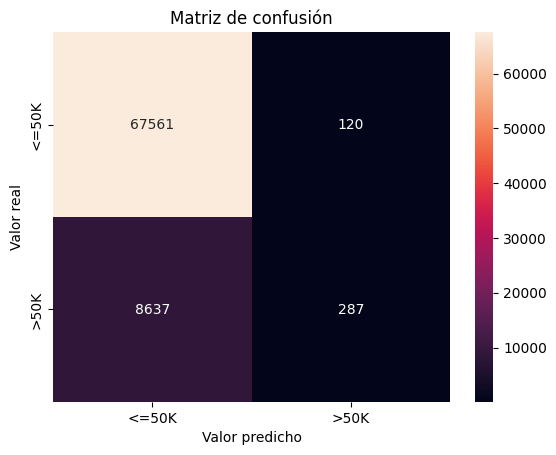

In [50]:
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_test_pred)
sns.heatmap(matriz_confusion, annot=True, fmt='d', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
plt.title("Matriz de confusión")
plt.show();